In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_ta as ta   ~~ Uncomment if the issue with pandas_ta is resolved

## Feature Engineering


- First let's do the minimal cleaning steps

In [2]:
#Get the data again, skip first 3 rows and set column names
data_path = '../data/sp500.csv'
col_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv(data_path, skiprows=3, names=col_names)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
numeric_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.ffill(inplace=True)
df.dropna(inplace=True)


In [3]:
if 'Daily_Return' not in df.columns:
    df['Daily_Return'] = df['Close'].pct_change() * 100
    df.dropna(subset=['Daily_Return'], inplace=True)


#print("Data loaded and initially prepared:")
#print(df.head())
#print(f"\nData shape: {df.shape}")
#print(f"\nDate range: {df.index.min()} to {df.index.max()}")

### Feature 1: Lagged Returns

In [4]:
n_lags = 5
for i in range(1, n_lags + 1):
    df[f'Return_Lag_{i}'] = df['Daily_Return'].shift(i)

### Feature 2: Rolling Volatilty

In [5]:
volatility_window = 21 
trading_days_per_year = 252 
if 'Daily_Return' in df.columns:
    df['Rolling_Std_Dev'] = df['Daily_Return'].rolling(window=volatility_window).std()
    df['Annualized_Volatility'] = df['Rolling_Std_Dev'] * np.sqrt(trading_days_per_year)
else:
    print("Warning: Daily_Return column needed for volatility calculation.")


### Feature 3: Volume

In [6]:
volume_window = 50
df['Volume_SMA'] = df['Volume'].rolling(window=volume_window).mean()
df['Volume_Ratio'] = df['Volume'] / (df['Volume_SMA'] + 1e-6) # Avoid division by zero

### Feature 4: Moving Averages

In [7]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean() 
df['SMA_200'] = df['Close'].rolling(window=200).mean()
# Calculate ratio between short/medium and long term trends
df['SMA_Ratio_50_200'] = df['SMA_50'] / (df['SMA_200'] + 1e-6)

### Feature 5: Time

In [8]:
df['Day_Of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
#df['Year'] = df.index.year  ~~can add later if needed

### Get Rid of NaNs

In [9]:
#Clean up NaNs introduced by shifts and rolling windows
print(f"\nNaNs before final drop:\n{df.isnull().sum()}")
df.dropna(inplace=True)
print(f"\nNaNs after final drop:\n{df.isnull().sum()}")
print(f"\nShape after feature engineering & NaN drop: {df.shape}")



NaNs before final drop:
Close                      0
High                       0
Low                        0
Open                       0
Volume                     0
Daily_Return               0
Return_Lag_1               1
Return_Lag_2               2
Return_Lag_3               3
Return_Lag_4               4
Return_Lag_5               5
Rolling_Std_Dev           20
Annualized_Volatility     20
Volume_SMA                49
Volume_Ratio              49
SMA_10                     9
SMA_50                    49
SMA_200                  199
SMA_Ratio_50_200         199
Day_Of_Week                0
Month                      0
dtype: int64

NaNs after final drop:
Close                    0
High                     0
Low                      0
Open                     0
Volume                   0
Daily_Return             0
Return_Lag_1             0
Return_Lag_2             0
Return_Lag_3             0
Return_Lag_4             0
Return_Lag_5             0
Rolling_Std_Dev          0
Annua

In [10]:
feature_columns = [f'Return_Lag_{i}' for i in range(1, n_lags + 1)] + \
                  ['Annualized_Volatility', 'Volume_Ratio',
                   'SMA_Ratio_50_200',
                   'Day_Of_Week', 'Month']

#You could also include the raw SMA values if desired, e.g., 'SMA_10', 'SMA_50'
#feature_columns.extend(['SMA_10', 'SMA_50'])


print(feature_columns)

['Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'Annualized_Volatility', 'Volume_Ratio', 'SMA_Ratio_50_200', 'Day_Of_Week', 'Month']


In [11]:
print(f"\nDataFrame head with engineered features:")
print(df[feature_columns + ['Daily_Return']].head()) # Show features and target


target_column = 'Daily_Return'


DataFrame head with engineered features:
            Return_Lag_1  Return_Lag_2  Return_Lag_3  Return_Lag_4  \
Date                                                                 
1970-10-15      0.154657     -0.130689     -1.069586     -1.012211   
1970-10-16      0.546382      0.154657     -0.130689     -1.069586   
1970-10-19     -0.437097      0.546382      0.154657     -0.130689   
1970-10-20     -1.340766     -0.437097      0.546382      0.154657   
1970-10-21      0.589294     -1.340766     -0.437097      0.546382   

            Return_Lag_5  Annualized_Volatility  Volume_Ratio  \
Date                                                            
1970-10-15     -1.081830              12.324530      0.869653   
1970-10-16     -1.012211              12.382907      0.868496   
1970-10-19     -1.069586              13.314065      0.759519   
1970-10-20     -0.130689              13.032340      0.812542   
1970-10-21      0.154657              13.022202      0.860785   

           

## Train/Val/Test

In [12]:
#Define Split Date
train_end_date = '2017-12-31'
validation_end_date = '2020-12-31'
#The test data will be everything after validation_end_date

In [13]:
# Training Set
df_train = df.loc[:train_end_date]

# Validation Set
df_val = df.loc[pd.to_datetime(train_end_date) + pd.Timedelta(days=1) : validation_end_date]

# Test Set
df_test = df.loc[pd.to_datetime(validation_end_date) + pd.Timedelta(days=1):]

In [14]:
#Features and targets
X_train = df_train[feature_columns]
y_train = df_train[target_column]

X_val = df_val[feature_columns]
y_val = df_val[target_column]

X_test = df_test[feature_columns]
y_test = df_test[target_column]

In [15]:
#Verify the Split
print("--- Data Split Verification ---")
print(f"Total data shape: {df.shape}")
print("-" * 30)
print(f"Training Set:")
print(f"  Date Range: {df_train.index.min().date()} to {df_train.index.max().date()}")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print("-" * 30)
print(f"Validation Set:")
print(f"  Date Range: {df_val.index.min().date()} to {df_val.index.max().date()}")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print("-" * 30)
print(f"Test Set:")
print(f"  Date Range: {df_test.index.min().date()} to {df_test.index.max().date()}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

--- Data Split Verification ---
Total data shape: (13671, 21)
------------------------------
Training Set:
  Date Range: 1970-10-15 to 2017-12-29
  X_train shape: (11910, 10)
  y_train shape: (11910,)
------------------------------
Validation Set:
  Date Range: 2018-01-02 to 2020-12-31
  X_val shape: (756, 10)
  y_val shape: (756,)
------------------------------
Test Set:
  Date Range: 2021-01-04 to 2024-12-31
  X_test shape: (1005, 10)
  y_test shape: (1005,)


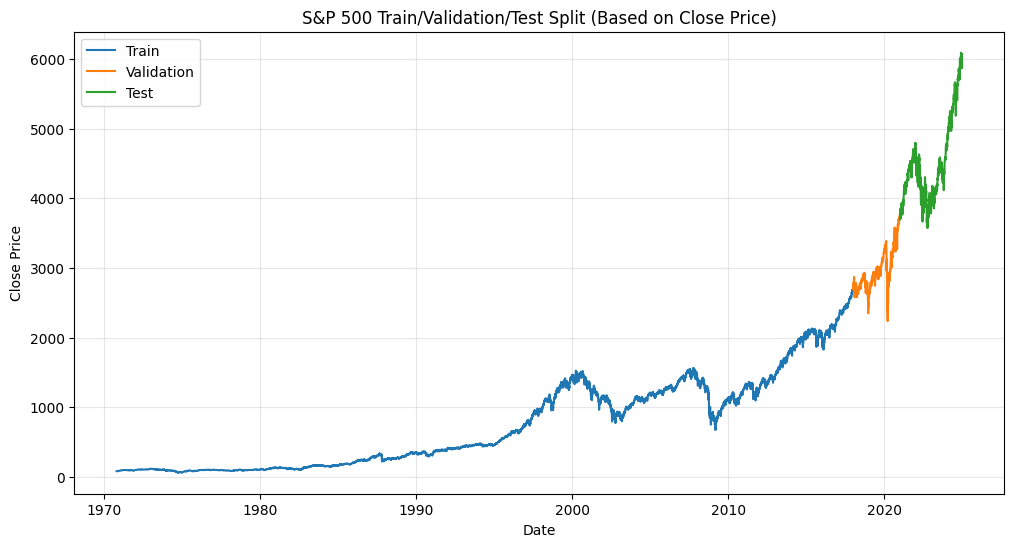

In [16]:
#Plot the splits visually
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['Close'], label='Train')
plt.plot(df_val.index, df_val['Close'], label='Validation')
plt.plot(df_test.index, df_test['Close'], label='Test')
plt.title('S&P 500 Train/Validation/Test Split (Based on Close Price)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Scaling Data

In [17]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler() #Features between 0 and 1


scaler.fit(X_train) # Fit the scaler on the training data



#Transform the data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [18]:
#Convert scaled data back into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


In [19]:
#Verify the Scaling
print("\n--- Scaled Data Verification ---")
print("Original X_train head:")
print(X_train.head())
print("\nScaled X_train head (MinMaxScaler to [0, 1]):")
print(X_train_scaled_df.head())


--- Scaled Data Verification ---
Original X_train head:
            Return_Lag_1  Return_Lag_2  Return_Lag_3  Return_Lag_4  \
Date                                                                 
1970-10-15      0.154657     -0.130689     -1.069586     -1.012211   
1970-10-16      0.546382      0.154657     -0.130689     -1.069586   
1970-10-19     -0.437097      0.546382      0.154657     -0.130689   
1970-10-20     -1.340766     -0.437097      0.546382      0.154657   
1970-10-21      0.589294     -1.340766     -0.437097      0.546382   

            Return_Lag_5  Annualized_Volatility  Volume_Ratio  \
Date                                                            
1970-10-15     -1.081830              12.324530      0.869653   
1970-10-16     -1.012211              12.382907      0.868496   
1970-10-19     -1.069586              13.314065      0.759519   
1970-10-20     -0.130689              13.032340      0.812542   
1970-10-21      0.154657              13.022202      0.860785 

In [20]:
print("\nScaled X_val head:") # Show the scaled validation set
print(X_val_scaled_df.head())

#we leave the target variable (y) unscaled for interpretability (for now).


Scaled X_val head:
            Return_Lag_1  Return_Lag_2  Return_Lag_3  Return_Lag_4  \
Date                                                                 
2018-01-02      0.622481      0.644377      0.641122      0.635352   
2018-01-03      0.664564      0.622481      0.644377      0.641122   
2018-01-04      0.658621      0.664564      0.622481      0.644377   
2018-01-05      0.651225      0.658621      0.664564      0.622481   
2018-01-08      0.660603      0.651225      0.658621      0.664564   

            Return_Lag_5  Annualized_Volatility  Volume_Ratio  \
Date                                                            
2018-01-02      0.637225               0.029146      0.313468   
2018-01-03      0.635352               0.031250      0.327192   
2018-01-04      0.641122               0.031361      0.340850   
2018-01-05      0.644377               0.031078      0.297558   
2018-01-08      0.622481               0.030570      0.299369   

            SMA_Ratio_50_200  Day

## Creating Sequences

We transform our flat table of features over time into the kind of "lookback windows" that LSTMs and Transformers need.
- 30 days is a good window for the sequence

In [21]:
def create_sequences(X_data, y_data, sequence_length):
    """
    Generates sequences from time series data for LSTM/Transformer models.

    Args:
        X_data (np.array): Array of input features (scaled). Shape (num_datapoints, num_features).
        y_data (pd.Series or np.array): Array of target variable. Shape (num_datapoints,).
        sequence_length (int): Number of time steps in each input sequence.

    Returns:
        tuple: (np.array of X sequences, np.array of y targets)
               X shape: (num_samples, sequence_length, num_features)
               y shape: (num_samples,)
    """
    X_sequences = []
    y_sequences = []


    if not isinstance(y_data, np.ndarray):
        y_data = y_data.to_numpy()



    #Iterate through the data to create sequences
    for i in range(len(X_data) - sequence_length):
        #Input sequence: from index i to i + sequence_length - 1
        X_sequences.append(X_data[i : i + sequence_length])
        #Target: the value at index i + sequence_length
        y_sequences.append(y_data[i + sequence_length])

    return np.array(X_sequences), np.array(y_sequences)

In [22]:
SEQUENCE_LENGTH = 30 # Look back 30 days


if isinstance(X_train_scaled, pd.DataFrame): #Check if conversion to DataFrame happened
    X_train_np = X_train_scaled.values
    X_val_np = X_val_scaled.values
    X_test_np = X_test_scaled.values
else: #Assume they are already NumPy arrays
    X_train_np = X_train_scaled
    X_val_np = X_val_scaled
    X_test_np = X_test_scaled


X_train_seq, y_train_seq = create_sequences(X_train_np, y_train, SEQUENCE_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_np, y_val, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_np, y_test, SEQUENCE_LENGTH)

In [23]:
#Verify the Shapes
print("\nSequence Shapes Verification")
print(f"X_train shape: {X_train_np.shape} -> X_train_seq shape: {X_train_seq.shape}")
print(f"y_train shape: {y_train.shape} -> y_train_seq shape: {y_train_seq.shape}")
print("-" * 30)
print(f"X_val shape:   {X_val_np.shape} -> X_val_seq shape:   {X_val_seq.shape}")
print(f"y_val shape:   {y_val.shape} -> y_val_seq shape:   {y_val_seq.shape}")
print("-" * 30)
print(f"X_test shape:  {X_test_np.shape} -> X_test_seq shape:  {X_test_seq.shape}")
print(f"y_test shape:  {y_test.shape} -> y_test_seq shape:  {y_test_seq.shape}")


Sequence Shapes Verification
X_train shape: (11910, 10) -> X_train_seq shape: (11880, 30, 10)
y_train shape: (11910,) -> y_train_seq shape: (11880,)
------------------------------
X_val shape:   (756, 10) -> X_val_seq shape:   (726, 30, 10)
y_val shape:   (756,) -> y_val_seq shape:   (726,)
------------------------------
X_test shape:  (1005, 10) -> X_test_seq shape:  (975, 30, 10)
y_test shape:  (1005,) -> y_test_seq shape:  (975,)


# LSTM Model Definition

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt



Let's first start off with a simple (Sequential) LSTM model with where all layers are stacked linearly. 

In [ ]:
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2]) # (sequence_length, num_features)

#Initiate the LSTM model
model = Sequential(name="SP500_LSTM_v1")

#LSTM Layer 1
model.add(LSTM(units=50, return_sequences=False, input_shape=input_shape))

#Dropout Layer (for regularization)
model.add(Dropout(rate=0.2)) # 20% dropout rate

#Output Layer (Dense)
#units=1 because we are predicting a single value (Daily_Return)
#activation=None or 'linear' for regression tasks
model.add(Dense(units=1, activation='linear')) # 'linear' is default


#Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

#Print Model Summary
#model.summary()

c:\Users\arash\Desktop\S&P500\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "SP500_LSTM_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,251 (47.86 KB)

 Trainable params: 12,251 (47.86 KB)

 Non-trainable params: 0 (0.00 B)

Define callbacks in case the model is not improving over time.

In [26]:
#ModelCheckpoint: Save the model weights only when validation loss improves
checkpoint_filepath = '../models/lstm_best_model.keras' # Use .keras format
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # Save entire model structure + weights
    monitor='val_loss',
    mode='min',
    save_best_only=True)

#EarlyStopping: Stop training if validation loss doesn't improve for 'patience' epochs
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, # Stop after 10 epochs of no improvement
    mode='min',
    restore_best_weights=True) # Restore weights from the epoch with the best monitor value

### Model Training

In [ ]:
#epochs: Number of times to iterate over the entire training dataset
#batch_size: Number of samples per gradient update
EPOCHS = 100 
BATCH_SIZE = 32 

print("\nStarting Model Training")

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq), 
    callbacks=[model_checkpoint_callback, early_stopping_callback], #Add callbacks
    verbose=1 
)

print("\nModel Training Finished")

#model.save('../models/lstm_final_model.keras') 


Starting Model Training
Epoch 1/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.0940 - mean_absolute_error: 0.7162 - val_loss: 2.1811 - val_mean_absolute_error: 0.8887
Epoch 2/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 1.1897 - mean_absolute_error: 0.7117 - val_loss: 2.1784 - val_mean_absolute_error: 0.8877
Epoch 3/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 1.1643 - mean_absolute_error: 0.7204 - val_loss: 2.1778 - val_mean_absolute_error: 0.8876
Epoch 4/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 1.0553 - mean_absolute_error: 0.7100 - val_loss: 2.1770 - val_mean_absolute_error: 0.8864
Epoch 5/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 1.1496 - mean_absolute_error: 0.7237 - val_loss: 2.1768 - val_mean_absolute_error: 0.8860
Epoch 6/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 1.1264 - mean_absolute_error: 0.7171 - val_loss: 2.1780 - val_mean_absolute_error: 0.8846
Epoch 7/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - loss

After only 35 epochs, the LSTM model terminated because the validation loss did not improve over the last 10 epochs. From the training history plot below, you can clearly see that the model is overfitting the training data, and thus not making richt predictions for the validation set.

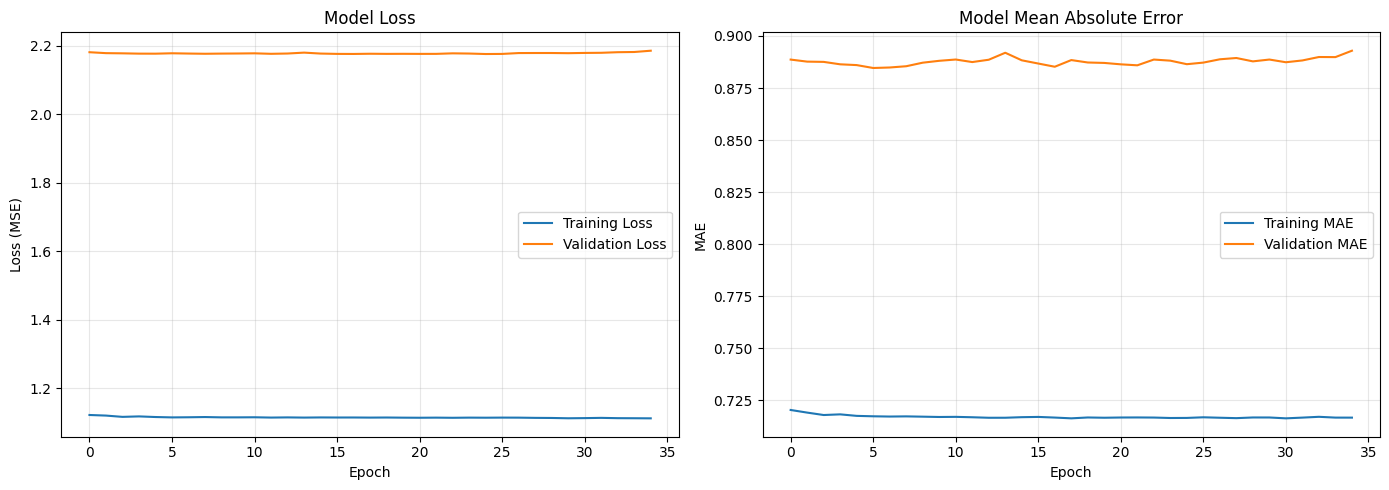

In [ ]:
#Plot Training History

def plot_training_history(history):
    """Plots loss and metrics from Keras training history."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    #Plot Loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

  
    metric_key = None
    for key in history.history.keys():
        if 'mean_absolute_error' in key and 'val_' not in key:
            metric_key = key
            break

    if metric_key:
        val_metric_key = f'val_{metric_key}'
        axes[1].plot(history.history[metric_key], label='Training MAE')
        if val_metric_key in history.history:
             axes[1].plot(history.history[val_metric_key], label='Validation MAE')
        axes[1].set_title('Model Mean Absolute Error')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
         axes[1].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Before fine-tuning the model (or switching to a completely different one) we have to see how well the model performs on the test set:

In [33]:
#Load the Best Model (so far)
best_model_path = '../models/lstm_best_model.keras'
try:
    print(f"\nLoading best model from: {best_model_path}")
    model = tf.keras.models.load_model(best_model_path)
except Exception as e:
    print(f"Error loading model: {e}")

#Evaluate on Test Set
print("\nEvaluating model on Test Set")
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")

#Calculate Directional Accuracy
print("\nCalculating Directional Accuracy on Test Set")
y_pred_test = model.predict(X_test_seq)



# Flatten y_pred_test if it's not already 1D
y_pred_test_flat = y_pred_test.flatten() 

#Compare signs (True if signs match, False otherwise)
epsilon = 1e-9  # Small value to avoid division by zero
correct_direction = (np.sign(y_pred_test_flat) * np.sign(y_test_seq + epsilon)) > 0 


directional_accuracy = np.mean(correct_direction) * 100  
print(f"Directional Accuracy: {directional_accuracy:.2f}%") # This is the percentage of correct directional predictions


Loading best model from: ../models/lstm_best_model.keras

Evaluating model on Test Set
Test Loss (MSE): 1.0847
Test Mean Absolute Error (MAE): 0.7674

Calculating Directional Accuracy on Test Set
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Directional Accuracy: 52.82%


Notes:
- The MAE is still a lot (0.77%)
- The directional Accuracy shows that this model is merely 2.82 percentage points better than a regular coin toss.
- we have to perform some hyperparameter tuning and adding/removing some features, before moving on to a different model architecture.

## Hyperparameter Tuning: LSTM

In [34]:
#OLD: SEQUENCE_LENGTH = 30
SEQUENCE_LENGTH = 60 #New sequence length for re-training

print(f"Creating sequences with length {SEQUENCE_LENGTH}...")
X_train_seq, y_train_seq = create_sequences(X_train_np, y_train, SEQUENCE_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_np, y_val, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_np, y_test, SEQUENCE_LENGTH)



Creating sequences with length 60...


In [36]:
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
print(f"Input shape for LSTM: {input_shape}") #Should now be (60, num_features)

#Build the LSTM Model
model = Sequential(name="SP500_LSTM_v2_Units100_Seq60") 

#LSTM Layer 1
model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape)) #More units for more complexity

#Dropout Layer
model.add(Dropout(rate=0.2))

#Output Layer
model.add(Dense(units=1, activation='linear'))

#Compile the Model 
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

#Print Model Summary
#model.summary()

Input shape for LSTM: (60, 10)


In [37]:
#Define new Callbacks 
checkpoint_filepath = '../models/lstm_v2_best_model.keras' 
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True)

In [38]:
#Train the Model
EPOCHS = 100
BATCH_SIZE = 32
print("\nStarting Model Training (v2: Units=100, Seq=60)")
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    verbose=1
)
print("\nModel Training Finished")


Starting Model Training (v2: Units=100, Seq=60)
Epoch 1/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 1.0660 - mean_absolute_error: 0.7155 - val_loss: 2.2270 - val_mean_absolute_error: 0.8999
Epoch 2/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 1.0456 - mean_absolute_error: 0.7118 - val_loss: 2.2170 - val_mean_absolute_error: 0.8909
Epoch 3/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 1.1935 - mean_absolute_error: 0.7193 - val_loss: 2.2109 - val_mean_absolute_error: 0.8850
Epoch 4/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 1.1800 - mean_absolute_error: 0.7308 - val_loss: 2.2108 - val_mean_absolute_error: 0.8829
Epoch 5/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 1.1603 - mean_absolute_error: 0.7280 - val_loss: 2.2153 - val_mean_absolute_error: 0.8913
Epoch 6/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 1.1592 - mean_absolute_error: 0.7250 - val_loss: 2.2102 - val_mean_absolute_error: 0.8853
Epoch 7/100
371/371 ━━━━━━━━━━━━━

In [40]:
#Load the Best Model
best_model_path = '../models/lstm_v2_best_model.keras'
try:
    print(f"\nLoading best model from: {best_model_path}")
    model = tf.keras.models.load_model(best_model_path)
except Exception as e:
    print(f"Error loading model: {e}")

#Evaluate on Test Set
print("\nEvaluating model on Test Set")
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")

#Calculate Directional Accuracy
print("\nCalculating Directional Accuracy on Test Set")
y_pred_test = model.predict(X_test_seq)



# Flatten y_pred_test if it's not already 1D
y_pred_test_flat = y_pred_test.flatten() 

#Compare signs (True if signs match, False otherwise)
epsilon = 1e-9  # Small value to avoid division by zero
correct_direction = (np.sign(y_pred_test_flat) * np.sign(y_test_seq + epsilon)) > 0 


directional_accuracy = np.mean(correct_direction) * 100  
print(f"Directional Accuracy: {directional_accuracy:.2f}%") # This is the percentage of correct directional predictions


Loading best model from: ../models/lstm_v2_best_model.keras

Evaluating model on Test Set
Test Loss (MSE): 1.0839
Test Mean Absolute Error (MAE): 0.7655

Calculating Directional Accuracy on Test Set
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Directional Accuracy: 52.80%


Notes:
- The refined model had extra units and larger sequences of data
- Despite that, the MSE was still too high, and the directional accuracy is still aligned with a coin toss

## LSTM Architecture Refinement

- For the last LSTM model I changed the arcitecture by adding a dense layer and a dropout layer
- I also added the Adam optimizer for learning rate adjustments

In [41]:
from tensorflow.keras.optimizers import Adam #For learning rate adjustments



input_shape = (X_train_seq.shape[1], X_train_seq.shape[2]) #(60, num_features)
print(f"Input shape for LSTM: {input_shape}") 

#Build the Modified LSTM Model
model = Sequential(name="SP500_LSTM_v3_DenseLayer") 

#LSTM Layer (using settings from v2)
model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))

#Dropout after LSTM
model.add(Dropout(rate=0.2)) 


model.add(Dense(units=50, activation='relu')) #Intermediate Dense Layer


#NEW Dropout after Intermediate Dense Layer
model.add(Dropout(rate=0.2)) #

#Final Output Layer (remains the same)
model.add(Dense(units=1, activation='linear'))


#Using 'adam' optimizer with default learning rate for now
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error']) 

#Print Model Summary
#model.summary()

Input shape for LSTM: (60, 10)


In [42]:
#New callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_filepath = '../models/lstm_v3_dense_best_model.keras' 
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, #Still using 10 epochs patience
    mode='min',
    restore_best_weights=True)

In [43]:
EPOCHS = 100 #Keep the same maximum epochs
BATCH_SIZE = 32 #Keep the same batch size

print("\n--- Starting Model Training (v3: LSTM + Dense Layer) ---")
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    verbose=1
)
print("\n--- Model Training Finished ---")


--- Starting Model Training (v3: LSTM + Dense Layer) ---
Epoch 1/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 1.0939 - mean_absolute_error: 0.7263 - val_loss: 2.2135 - val_mean_absolute_error: 0.8853
Epoch 2/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 1.1227 - mean_absolute_error: 0.7150 - val_loss: 2.2114 - val_mean_absolute_error: 0.8840
Epoch 3/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 1.1122 - mean_absolute_error: 0.7220 - val_loss: 2.2130 - val_mean_absolute_error: 0.8868
Epoch 4/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 1.1022 - mean_absolute_error: 0.7207 - val_loss: 2.2141 - val_mean_absolute_error: 0.8880
Epoch 5/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 1.1318 - mean_absolute_error: 0.7249 - val_loss: 2.2108 - val_mean_absolute_error: 0.8835
Epoch 6/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 1.1244 - mean_absolute_error: 0.7239 - val_loss: 2.2111 - val_mean_absolute_error: 0.8846
Epoch 7/100
371/371 ━━━━